# RETINAFACE案例

RETINAFACE是用于人脸对齐的常用网络，论文中模型在Wider Face数据集上进行训练，并取得了较好的对齐效果。本文将以传统人脸对齐数据集WIDER FACE为例，讲述如何在MindSpore中建立RETINAFACE模型进行人脸对齐的训练和验证。

## 模型简介

在模型设计上，Retinaface考虑到应用场景的不同，以及为了更综合的考虑网络结构的性能，模型提供了两种不同的骨干网，分别为庞大的ResNet50和方便部署的MobileNet025。在骨干网将特征提取完毕后，模型通过特征金字塔以及SSH模块，分别进行多尺度提取和多任务学习。

![retinaface_structure](./images/retinaface_structure1.png)

最终根据SSH模块的不同输出对图片进行人脸对齐的不同工作，具体工作包含人脸对齐以及人脸关键点检测。其中模型本身可以预测人脸关键点，通过FPN(特征金字塔)、SSH以及anchor结构可以检测不同大小的人脸并进行对齐。

### FPN结构

RetinaFace的backbone与其他网络类似，采用了特征提取效果比较好的resnet网络作为backbone。在应对实时检测问题上，将backbone换为轻量级的mobilenet网络也是业内常见的做法。

RetinaFace之所以能在多尺度上都获得比较好的检测效果，主要得益于FPN结构，下图就是FPN结构图。

![FPN](./images/FPN.png)

由图中的结构可以看出，P5是来自backbone深层的输出，代表着输入图像的全局特征（如：轮廓，形状等），P2是backbone浅层的输出，代表着输入图像的局部特征（如：纹理，角点等）。FPN的主要作用就是：

1. 通过上采样，将全局特征与局部特征进行融合，从而增强对目标的检测效果。
2. FPN结构中，不同层的输出也代表了不同尺度上的特征提取结果。

### SSH结构

![SSH](./images/SSH.png)

通过FPN部分的运算，我们获得了P3、P4、P5三个有效特征层。Retinaface为了进一步加强特征提取，使用了SSH模块加强感受野。SSH使用了三个并行结构，利用3x3卷积的堆叠代替5x5与7x7卷积的效果。SSH的主要作用就是：

在特征图中引入上下文信息来提高小人脸的检测,将前后卷积产生的两个不同channel的特征图进行融合，从而获取较好的上下文。

### anchor结构

目标检测一般都是采用anchor_based的方法，大致可以分为单阶段检测器和双阶段检测器。它们都是在一张图片上放置大量的预先定义好的 anchor boxes，然后预测其类别，优化这些anchor boxes的坐标，最终将这些优化后的 anchor boxes作为检测结果输出。anchor在模型中的具体实现将在后文中结合代码进行解读。

## 模型输出

基础的RetinaFace网络的输出由三部分组成。

![retinaface_output](./images/retinaface_output2.png)

由网络结构图可以看出，RetinaFace网络输出三个部分的内容：Face Classification，Face box regression, Facial landmark regression。如果以输入图像是640*640的图片为例。

Face Classification的输出是一个形如（1，16800，2）的矩阵，代表了所有anchor位置是否存在人脸。

Face box regression的输出是一个形如（1，16800，4）的矩阵，代表了所有anchor位置坐标点的回归值，通过对该值的处理可或得该区域的box坐标值。综合Face Classification的输出就可以筛选出最终的人脸框。

Facial landmark regression的输出是一个形如（1，16800，10）的矩阵，代表了每个anchor位置landmark点的回归值。由于WIDER FACE数据集给予每张人脸5个关键点的标注，所以最终的维度是10。

其中anchor的含义为模型预先在预测图片上生成的不同大小和位置预测框，模型通过检测预测框中是否有人脸进行人脸位置的预测。

## 1. 准备环节

进行实验之前请确保环境安装了Python环境，MindSpore1.5以上的版本，以及requirements.txt中标明的深度学习工具包。

### 1.1 导入模块

In [1]:
from __future__ import print_function
import os
import argparse
from typing import Optional
import cv2
import ast
import numpy as np
import mindspore as ms

from mindspore.communication.management import get_group_size
from mindspore.train import Model
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor

from src.model.retinaface import RetinaFace, TrainingWrapperResNet, TrainingWrapperMobileNet
from src.model.loss_cell import RetinaFaceWithLossCell
from src.model.resnet50 import resnet50
from src.model.mobilenet025 import MobileNetV1
from src.process_datasets.widerface import WiderFace
from src.utils.multiboxloss import MultiBoxLoss

from src.process_datasets.pre_process import PreProcessor
from src.utils.detection import BboxEncoder
from src.utils.timer import Timer
from src.utils.detection import prior_box
from src.utils.detection_engine import DetectionEngine
from src.utils.draw_prediction import read_input_images, cast_list_to_int, draw_preds

### 1.2 环境配置

使用GRAPH模式进行实验，使用GPU环境。

>ms.set_context(mode=ms.GRAPH_MODE, device_target='GPU', save_graphs=False)

### 1.3 数据集准备

#### 1.3.1 下载数据集

下载案例所用到的[人脸对齐数据集](http://shuoyang1213.me/WIDERFACE/index.html)，该数据集包含32203图像，以及393,703个标注人脸，其中，158,989个标注人脸位于训练集，39,496个位于验证集。每一个子集都包含3个级别的检测难度：Easy，Medium，Hard。这些人脸在尺度，姿态，光照、表情、遮挡方面都有很大的变化范围。
我们需要在网页中下载训练集(train)和验证集(valid)以及对应的标注(face annotations)。

#### 1.3.2 下载评估地面真实值标签

下载案例所用到的[ground_truth](https://github.com/peteryuX/retinaface-tf2/tree/master/widerface_evaluate/ground_truth)验证。该链接中的注释与官方提供的标注不同，链接中的ground_truth将三个不同级别检测难度的文件分别进行了整理保存。在实验中将使用该权重分别检测模型在不同难度数据集上的表现情况。

#### 1.3.3 下载完成后需要将数据集目录构建成如下形式

```text
├── data/
    ├── widerface/
        ├── ground_truth/
        │   ├──wider_easy_val.mat
        │   ├──wider_face_val.mat
        │   ├──wider_hard_val.mat
        │   ├──wider_medium_val.mat
        ├── train/
        │   ├──images/
        │   │   ├──0--Parade/
        │   │   │   ├──0_Parade_marchingband_1_5.jpg
        │   │   │   ├──...
        │   │   ├──.../
        │   ├──label.txt
        ├── val/
        │   ├──images/
        │   │   ├──0--Parade/
        │   │   │   ├──0_Parade_marchingband_1_20.jpg
        │   │   │   ├──...
        │   │   ├──.../
        │   ├──label.txt
```

## 2. 加载数据

### 2.1 在代码中中定义训练集和测试集的路径

In [2]:
training_dataset: '/root/rtf/new_code/data/widerface/train/label.txt'
val_dataset_folder: '/root/rtf/new_code/data/widerface/valid/'

完整的配置文件如下图所示：

In [3]:
def parse_args():
    """Parse configuration arguments for training."""
    parser = argparse.ArgumentParser(description='train')
    parser.add_argument('--backbone', default='mobilenet025', type=str, choices=['resnet50', 'mobilenet025'])
    parser.add_argument('--variance', default=[0.1, 0.2], type=float, nargs='+')
    parser.add_argument('--clip', default=False, type=bool)
    parser.add_argument('--loc_weight', default=2.0, type=float)
    parser.add_argument('--class_weight', default=1.0, type=float)
    parser.add_argument('--landm_weight', default=1.0, type=float)
    parser.add_argument('--batch_size', default=8, type=int)
    parser.add_argument('--num_anchor', default=16800, type=int)
    parser.add_argument('--image_size', default=640, type=int)
    parser.add_argument('--match_thresh', default=0.35, type=float)
    parser.add_argument('--in_channel', default=32, type=int)
    parser.add_argument('--out_channel', default=64, type=int)
    parser.add_argument('--seed', default=1, type=int)
    parser.add_argument('--epoch', default=1, type=int)
    parser.add_argument('--initial_lr', default=0.005, type=float)
    parser.add_argument('--ckpt_path', default='./ckps/', type=str)
    parser.add_argument('--save_checkpoint_steps', default=100, type=int)
    parser.add_argument('--keep_checkpoint_max', default=3, type=int)
    parser.add_argument('--training_dataset', default='/root/rtf/new_code/data/widerface/train/label.txt', type=str)
    parser.add_argument('--pretrain', default=False, type=bool)
    parser.add_argument('--pretrain_path', default='./pretrained_model/res50_pretrain.ckpt', type=str)
    parser.add_argument('--num_classes', default=2, type=int)
    parser.add_argument('--negative_ratio', default=7, type=int)
    parser.add_argument('--device_target', default='GPU', type=str)
    #  valid
    parser.add_argument('--val_model', default='/root/rtf/new_code/data/RetinaFace-6_1609.ckpt', type=str)
    parser.add_argument('--val_origin_size', default=False, type=bool)
    parser.add_argument('--val_dataset_folder', default='/root/rtf/new_code/data/widerface/valid/', type=str)
    parser.add_argument('--val_save_result', default=True, type=bool)
    parser.add_argument('--val_confidence_threshold', default=0.02, type=float)
    parser.add_argument('--val_nms_threshold', default=0.4, type=float)
    parser.add_argument('--val_iou_threshold', default=0.5, type=float)
    parser.add_argument('--val_predict_save_folder', default='/root/rtf/new_code/data/widerface_result', type=str)
    parser.add_argument('--val_gt_dir', default='/root/rtf/new_code/data/ground_truth/', type=str)
    parser.add_argument('--min_sizes', default='[[16, 32], [64, 128], [256, 512]]', type=str)
    parser.add_argument('--steps', default=[8, 16, 32], type=float, nargs='+')
    parser.add_argument('--image_average', default=(104.0, 117.0, 123.0), type=float, nargs='+')
    parser.add_argument('--target_size', default=840, type=int)
    parser.add_argument('--max_size', default=840, type=int)
    #  infer
    parser.add_argument('--img_folder', default='/root/rtf/new_code/application_example/retinaface/input_image', type=str)
    parser.add_argument('--draw_save_folder', default='/root/rtf/new_code/application_example/retinaface/infer_image', type=str)
    parser.add_argument('--conf_thre', default=0.4, type=float)
    return vars(parser.parse_args(()))
config = cfg = parse_args()
ms.common.seed.set_seed(cfg['seed'])
rank_id = 0
device_num = 1
batch_size = cfg['batch_size']
max_epoch = cfg['epoch']
training_dataset = cfg['training_dataset']
num_classes = 2
negative_ratio = 7

### 2.2 通过定义WiderFace类对数据进行读取

In [4]:
from typing import Optional
from mindspore import dataset as de
from src.process_datasets.pre_process import PreProcessor
from src.process_datasets.widerface import ParseWiderFace

class WiderFace:
    # A source dataset that reads, parses and augments the WiderFace dataset.
    def __init__(self,
                 path: str,
                 config: dict = None,
                 batch_size: int = 32,
                 repeat_num: int = 1,
                 python_multiprocessing: bool = False,
                 shuffle: Optional[bool] = None,
                 num_parallel_workers: int = 1,
                 num_shards: Optional[int] = None,
                 shard_id: Optional[int] = None):
        self.batch_size = batch_size
        self.repeat_num = repeat_num
        self.multiprocessing = python_multiprocessing
        self.num_parallel_workers = num_parallel_workers
        self.config = config
        self.parse_widerface = ParseWiderFace(label_path=path)
        if num_shards == 1:
            de_dataset = de.GeneratorDataset(self.parse_widerface, ["image", "annotation"],
                                             shuffle=shuffle,
                                             num_parallel_workers=num_parallel_workers)
        else:
            de_dataset = de.GeneratorDataset(self.parse_widerface, ["image", "annotation"],
                                             shuffle=shuffle,
                                             num_parallel_workers=num_parallel_workers,
                                             num_shards=num_shards,
                                             shard_id=shard_id)
        self.dataset = de_dataset

    def run(self):
        # Fetch data.
        aug = PreProcessor(self.config['image_size'])
        encode = BboxEncoder(self.config)

        def union_data(image, annot):
            cv2.setNumThreads(2)
            if isinstance(image, str):
                img = cv2.imread(image)
            else:
                img = cv2.imread(image.tostring().decode("utf-8"))
            labels = annot
            anns = np.zeros((0, 15))
            if labels.shape[0] <= 0:
                return anns
            for _, label in enumerate(labels):
                ann = np.zeros((1, 15))
                ann[0, 0:2] = label[0:2]
                ann[0, 2:4] = label[0:2] + label[2:4]
                ann[0, 4:14] = label[[4, 5, 7, 8, 10, 11, 13, 14, 16, 17]]
                if (ann[0, 4] < 0):
                    ann[0, 14] = -1
                else:
                    ann[0, 14] = 1
                anns = np.append(anns, ann, axis=0)
            target = np.array(anns).astype(np.float32)
            img, target = aug(img, target)
            out = encode(img, target)
            return out

        de_dataset = self.dataset.map(input_columns=["image", "annotation"],
                                      output_columns=["image", "truths", "conf", "landm"],
                                      column_order=["image", "truths", "conf", "landm"],
                                      operations=union_data,
                                      python_multiprocessing=self.multiprocessing,
                                      num_parallel_workers=self.num_parallel_workers)
        de_dataset = de_dataset.batch(self.batch_size, drop_remainder=True)
        de_dataset = de_dataset.repeat(self.repeat_num)
        return de_dataset

### 2.3 实例化数据集

可通过如下方式实例化数据集：

In [5]:
ds_train = WiderFace(path=training_dataset, config=cfg, batch_size=batch_size, repeat_num=1, shuffle=True, num_parallel_workers=1, num_shards=device_num, shard_id=rank_id, python_multiprocessing=False).run()
print('dataset size is : \n', ds_train.get_dataset_size())

dataset size is : 
 1609


## 3. 定义网络

对数据集进行初始化后就需要进行网络的构建了。网络构建将从骨干网络(ResNet/MobileNet)、特征强化模块(FPN、SSH)、连接网络、损失函数和优化器方面进行描述。

在下面的实验教程中，我们将通过示例代码说明如何设置网络、优化器、如何计算损失函数以及如何初始化模型权重。

### 3.1 骨干网络

RETINAFACE通过主干网络进行第一步的特征提取，之后通过FPN特征金字塔以及SSH模块进行加强特征提取，最后通过加强特征获得预测结果。

实验中使用的骨干网共有两种，分别为ResNet-50和MobileNet-v025，两种骨干网络都可以通过Model Zoo直接获取，在训练时通过调整参数对模型使用的骨干网络种类进行调节。

同时由于RETINAFACE模型需要在卷积过程中不同大小的特征输出以供FPN与SSH进行进一步的特征提取，因此我们对骨干网进行了更改，根据特征输出阶段将网络分为了三个部分，以ResNet50为例，我们的网络定义如下：


In [6]:
import numpy as np
from mindspore import nn, ops, Tensor
class ResNet(nn.Cell):
    def __init__(self,
                 block,
                 layer_nums,
                 in_channels,
                 out_channels,
                 strides,
                 num_classes):
        super(ResNet, self).__init__()

        if not len(layer_nums) == len(in_channels) == len(out_channels) == 4:
            raise ValueError("the length of layer_num, in_channels, out_channels list must be 4!")

        self.conv1 = _conv7x7(3, 64, stride=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = ops.ReLU()

        self.pad = ops.Pad(((0, 0), (0, 0), (1, 0), (1, 0)))
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode="valid")

        self.layer1 = self._make_layer(block,
                                       layer_nums[0],
                                       in_channel=in_channels[0],
                                       out_channel=out_channels[0],
                                       stride=strides[0])
        self.layer2 = self._make_layer(block,
                                       layer_nums[1],
                                       in_channel=in_channels[1],
                                       out_channel=out_channels[1],
                                       stride=strides[1])
        self.layer3 = self._make_layer(block,
                                       layer_nums[2],
                                       in_channel=in_channels[2],
                                       out_channel=out_channels[2],
                                       stride=strides[2])
        self.layer4 = self._make_layer(block,
                                       layer_nums[3],
                                       in_channel=in_channels[3],
                                       out_channel=out_channels[3],
                                       stride=strides[3])

        self.mean = ops.ReduceMean(keep_dims=True)
        self.flatten = nn.Flatten()
        self.end_point = _fc(out_channels[3], num_classes)

    def _make_layer(self, block, layer_num, in_channel, out_channel, stride):
        layers = []

        resnet_block = block(in_channel, out_channel, stride=stride)
        layers.append(resnet_block)

        for _ in range(1, layer_num):
            resnet_block = block(out_channel, out_channel, stride=1)
            layers.append(resnet_block)

        return nn.SequentialCell(layers)

    def construct(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pad(x)

        c1 = self.maxpool(x)

        c2 = self.layer1(c1)
        c3 = self.layer2(c2)
        c4 = self.layer3(c3)
        c5 = self.layer4(c4)

        out = self.mean(c5, (2, 3))
        out = self.flatten(out)
        out = self.end_point(out)

        return c3, c4, c5


说明：
>MobileNet网络的更改会在3.3中进行介绍。

### 3.2 损失函数

MindSpore将损失函数、优化器等操作都封装到了Cell中，RETINAFACE由于任务的特殊性，与传统的回归分类网络不同，需要自定义RetinaFaceWithLossCell类，将网络和Loss连接起来：

其中，retinaface使用multibosloss作为网络的损失函数，共有三部分组成，分别为loss_loc，loss_conf,loss_landm，与ssd的损失类似，分别代表人脸框，置信度和关键点

### multiboxloss

$$
\mathcal{L} =\mathcal{L}_{cls}\left (p_i,p_i^* \right )+\lambda_1p_i^*\mathcal{L}_{box}\left (t_i,t_i^* \right )+\lambda_2p_i^*\mathcal{L}_{pts}\left (l_i,l_i^* \right )+\lambda_3p_i^*\mathcal{L}_{pixel}
$$

>$Lcls$：人脸分类loss，这里的$pi$是anchor i为人脸的预测概率，对于$p_i^*$是1是positive anchor，0代表为negative anchor。分类loss $Lcls$采用softmax loss，即softmax loss在二分类的情况（人脸/非人脸）的应用。

>$Lbox$：人脸框回归loss，这里的$t_i=\left\{t_x,t_y,t_w,t_h\right\}$，$t_i^*=\left\{t_x^*,t_y^*,t_w^*,t_h^*\right\}$分别代表positive anchor相关的预测框和真实框（ground-truth box）的坐标。我们按照 Fast r-cnn的方法对回归框目标（中心坐标，宽和高）进行归一化，使用$\mathcal{L}_{box}\left(t_i,t_i^*\right)=R\left(t_i-t_i^*\right)$，这里$R$是 smooth-L1 Loss

>$Lpts$：人脸关键点回归loss，五点，这里$li=\left\{l x_1,l y_1,…,l x_5,l y_5\right\}$,$l_i^*=\left\{l x_1^*,l y_1^*,…,l x_5^*,l y_5^*\right\}$代表预测的五个人脸关键点和基准点（ground-truth）。五个人脸关键点的回归也采用了基于anchor中心的目标归一化。
Lpixel：自监督3D Mesh Renderer稠密人脸回归

In [7]:
class RetinaFaceWithLossCell(nn.Cell):

    def __init__(self, network, multibox_loss, config):
        super(RetinaFaceWithLossCell, self).__init__()
        self.network = network
        self.loc_weight = config['loc_weight']
        self.class_weight = config['class_weight']
        self.landm_weight = config['landm_weight']
        self.multibox_loss = multibox_loss

    def construct(self, img, loc_t, conf_t, landm_t):
        pred_loc, pre_conf, pre_landm = self.network(img)

        # loss conf
        loss_loc, loss_conf, loss_landm = self.multibox_loss(pred_loc, loc_t, pre_conf, conf_t, pre_landm, landm_t)

        return loss_loc * self.loc_weight + loss_conf * self.class_weight + loss_landm * self.landm_weight

### 3.3 连接网络和优化器

   在定义了连接器后，我们需要自定义损失类MultiBoxLoss，用于计算box框的回归损失，以及自定义训练类TrainingWarpper，通过自定义训练将损失函数和优化器添加到网络中。

   优化器我们采用MindSpore包含的Adam优化器进行梯度下降的优化。


In [8]:
class TrainingWrapper(nn.Cell):

    def __init__(self, network, optimizer, sens=1.0):
        super(TrainingWrapper, self).__init__(auto_prefix=False)
        self.network = network
        self.weights = ms.ParameterTuple(network.trainable_params())
        self.optimizer = optimizer
        self.grad = ops.GradOperation(get_by_list=True, sens_param=True)
        self.sens = sens
        self.reducer_flag = False
        self.grad_reducer = None
        self.parallel_mode = ms.get_auto_parallel_context("parallel_mode")
        class_list = [ms.ParallelMode.DATA_PARALLEL, ms.ParallelMode.HYBRID_PARALLEL]
        if self.parallel_mode in class_list:
            self.reducer_flag = True
        if self.reducer_flag:
            mean = ms.get_auto_parallel_context("gradients_mean")
            if auto_parallel_context().get_device_num_is_set():
                degree = ms.get_auto_parallel_context("device_num")
            else:
                degree = get_group_size()
            self.grad_reducer = nn.DistributedGradReducer(optimizer.parameters, mean, degree)

    def construct(self, *args):
        weights = self.weights
        loss = self.network(*args)
        sens = ops.Fill()(ops.DType()(loss), ops.Shape()(loss), self.sens)
        grads = self.grad(self.network, weights)(*args, sens)
        if self.reducer_flag:
            # apply grad reducer on grads
            grads = self.grad_reducer(grads)
        self.optimizer(grads)
        return loss

### 3.4 特征强化模块

#### 3.4.1 FPN特征金字塔

在RETINAFACE中骨干网络共进行三次特征输出，骨干网络会以该三次特征输出为边界将卷积层进行划分，以MobileNet为例，我们在MobileNetV1对骨干网的定义如下：

In [9]:
class MobileNetV1(nn.Cell):
    def __init__(self):
        super(MobileNetV1, self).__init__()
        self.stage1 = nn.SequentialCell([
            conv_bn(3, 8, 2, leaky=0.1),
            conv_dw(8, 16, 1),
            conv_dw(16, 32, 2),
            conv_dw(32, 32, 1),
            conv_dw(32, 64, 2),
            conv_dw(64, 64, 1),
        ])
        self.stage2 = nn.SequentialCell([conv_dw(64, 128, 2)] + [conv_dw(128, 128, 1)] * 5)
        self.stage3 = nn.SequentialCell([
            conv_dw(128, 256, 2),
            conv_dw(256, 256, 1),
        ])

    def construct(self, x):
        x1 = self.stage1(x)
        x2 = self.stage2(x1)
        x3 = self.stage3(x2)
        return x1, x2, x3

def conv_dw(in_channel, out_channel, stride, leaky=0.1):
    return nn.SequentialCell([
        nn.Conv2d(in_channels=in_channel, out_channels=in_channel, kernel_size=3, stride=stride, pad_mode='pad', padding=1, group=in_channel, has_bias=False),
        nn.BatchNorm2d(num_features=in_channel, momentum=0.9),
        nn.LeakyReLU(alpha=leaky),
        nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=1, stride=1, pad_mode='pad', padding=0, has_bias=False),
        nn.BatchNorm2d(num_features=out_channel, momentum=0.9),
        nn.LeakyReLU(alpha=leaky),
    ])


def conv_bn(in_channel, out_channel, stride=1, leaky=0):
    return nn.SequentialCell([
        nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=3, stride=stride, pad_mode='pad', padding=1, has_bias=False),
        nn.BatchNorm2d(num_features=out_channel, momentum=0.9),
        nn.LeakyReLU(alpha=leaky)
    ])

FPN特征金字塔会对采集到的特征进行特征融合，首先对长宽最小的有效特征层进行上采样改变通道数（并进行输出），然后将该上采样结果与骨干网中间层的输出相加（并进行输出），再将该相加结果通过卷积、上采样和骨干网最高层的输出进行相加。最终会输出三个同样长度的加强特征向量：

In [10]:
class FPN(nn.Cell):
    def __init__(self, in_channel=None, out_channel=None):
        super(FPN, self).__init__()
        norm_layer = nn.BatchNorm2d
        leaky = 0
        if in_channel is None or out_channel is None:
            self.output1 = ConvBNReLU(512, 256, kernel_size=1, stride=1, padding=0, groups=1,
                                      norm_layer=norm_layer, leaky=leaky)
            self.output2 = ConvBNReLU(1024, 256, kernel_size=1, stride=1, padding=0, groups=1,
                                      norm_layer=norm_layer, leaky=leaky)
            self.output3 = ConvBNReLU(2048, 256, kernel_size=1, stride=1, padding=0, groups=1,
                                      norm_layer=norm_layer, leaky=leaky)

            self.merge1 = ConvBNReLU(256, 256, kernel_size=3, stride=1, padding=1, groups=1,
                                     norm_layer=norm_layer, leaky=leaky)
            self.merge2 = ConvBNReLU(256, 256, kernel_size=3, stride=1, padding=1, groups=1,
                                     norm_layer=norm_layer, leaky=leaky)
        else:
            out_channels = out_channel
            if out_channels <= 64:
                leaky = 0.1
            self.output1 = ConvBNReLU(in_channel * 2, out_channel, kernel_size=1, stride=1,
                                      padding=0, groups=1, norm_layer=norm_layer, leaky=leaky)
            self.output2 = ConvBNReLU(in_channel * 4, out_channel, kernel_size=1, stride=1,
                                      padding=0, groups=1, norm_layer=norm_layer, leaky=leaky)
            self.output3 = ConvBNReLU(in_channel * 8, out_channel, kernel_size=1, stride=1,
                                      padding=0, groups=1, norm_layer=norm_layer, leaky=leaky)

            self.merge1 = ConvBNReLU(out_channel, out_channel, kernel_size=3, stride=1, padding=1,
                                     groups=1,
                                     norm_layer=norm_layer, leaky=leaky)
            self.merge2 = ConvBNReLU(out_channel, out_channel, kernel_size=3, stride=1, padding=1,
                                     groups=1,
                                     norm_layer=norm_layer, leaky=leaky)

    def construct(self, input1, input2, input3):
        output1 = self.output1(input1)
        output2 = self.output2(input2)
        output3 = self.output3(input3)

        up3 = ops.ResizeNearestNeighbor([ops.Shape()(output2)[2], ops.Shape()(output2)[3]])(output3)
        output2 = up3 + output2
        output2 = self.merge2(output2)

        up2 = ops.ResizeNearestNeighbor([ops.Shape()(output1)[2], ops.Shape()(output1)[3]])(output2)
        output1 = up2 + output1
        output1 = self.merge1(output1)

        return output1, output2, output3

#### 3.4.2 SSH模块

SSH模块会将不同次数卷积的输出进行相连Concat，增大了卷积的感受野，再次提高检测模块多尺度检测的能力。他分别使用一次3X3、2次3X3、3次3X3卷积(SSH通过2次3X3卷积模拟5X5卷积，通过3次3X3卷积模拟7X7卷积)对FPN输出的特征向量进行提取，提取结果会进行相加：

In [11]:
class SSH(nn.Cell):
    def __init__(self, in_channel, out_channel):
        super(SSH, self).__init__()
        if out_channel % 4 != 0:
            raise RuntimeError('The number of output channels must be a multiple of 4.')
        leaky = 0
        if out_channel <= 64:
            leaky = 0.1

        norm_layer = nn.BatchNorm2d
        self.conv3x3 = ConvBN(in_channel, out_channel // 2, kernel_size=3, stride=1, padding=1, groups=1,
                              norm_layer=norm_layer)

        self.conv5x5_1 = ConvBNReLU(in_channel, out_channel // 4, kernel_size=3, stride=1, padding=1, groups=1,
                                    norm_layer=norm_layer, leaky=leaky)
        self.conv5x5_2 = ConvBN(out_channel // 4, out_channel // 4, kernel_size=3, stride=1, padding=1, groups=1,
                                norm_layer=norm_layer)

        self.conv7x7_2 = ConvBNReLU(out_channel // 4, out_channel // 4, kernel_size=3, stride=1, padding=1, groups=1,
                                    norm_layer=norm_layer, leaky=leaky)
        self.conv7x7_3 = ConvBN(out_channel // 4, out_channel // 4, kernel_size=3, stride=1, padding=1, groups=1,
                                norm_layer=norm_layer)

        self.cat = ops.Concat(axis=1)
        self.relu = nn.ReLU()

    def construct(self, x):
        conv3x3 = self.conv3x3(x)

        conv5x5_1 = self.conv5x5_1(x)
        conv5x5 = self.conv5x5_2(conv5x5_1)

        conv7x7_2 = self.conv7x7_2(conv5x5_1)
        conv7x7 = self.conv7x7_3(conv7x7_2)

        out = self.cat((conv3x3, conv5x5, conv7x7))
        out = self.relu(out)

        return out

#### 3.4.3 anchor结构

目标检测一般都是采用anchor_based的方法，大致可以分为单阶段检测器和双阶段检测器。它们都是在一张图片上放置大量的预先定义好的 anchor boxes，然后预测其类别，优化这些anchor boxes的坐标，最终将这些优化后的 anchor boxes作为检测结果输出。本案例就是在单阶段检测器中应用anchor。

由于FPN和 Focal Loss 的出现，最近学术领域又开始关注在 anchor-free 检测器上。Anchor-free 检测器以两种不同的方式来直接找到物体，无需预先定义 anchors。一种方式是首先定位到多个预定义或自学习的关键点，然后约束物体的空间范围。作者称这种 anchor-free 方法为 keypoint-based 方法（基于关键点的方法）。另一种就是利用中心点或中心目标区域来定义正样本，然后预测它到目标四个边的距离。这类 anchor-free 方法被称作为 center-based 方法（基于中心点的方法）。这些 anchor-free 方法降低了有关anchor的超参数，取得的效果与 anchor-based 方法类似，使它们更具泛化潜能。

keypoint-based methods：这类 anchor-free 方法首先定位到预先定义或自学习的关键点，然后生成边框来检测物体。CornerNet 通过一对关键点（左上角和右下角）来检测物体的边框，CornerNet-Lite 引入了 CornerNet-Saccade 和 CornerNet-Squeeze 来提升其速度。Grid R-CNN 的第二个阶段利用FCN的位置敏感的优点来预测网格点，然后再判断边框、定位物体。ExtremeNet 检测物体的4个点（最上面、最左面、最下面、最右面）以及一个中心点来生成物体的边框。Zhu 等人利用关键点估计来找到物体的中心点，然后回归出其他的属性，包括大小、三维位置、朝向、姿态等。CenterNet 扩展了CornerNet，通过三个点而不是两个点来提升精度和召回率。RepPoints 将物体表示为一个样本点的集合，通过约束物体的空间范围、强调语义重要的局部区域来学习。

本文使用了keypoint-based的方法，对于输入的640X640的图像缩放到80X80，40X40，20X20三个尺度，同时在缩放后的每个特征图上生成2个不同大小的正方形anchor用于目标检测。从下列代码中，可以看到anchor的生成方法。

In [12]:
# image_sizes代表了输入图像的尺寸，min_sizes规范了anchor框的宽和高
# step与image_sizes配合计算缩放后的特征图尺寸，clip用于限定输出anchor的值在（0，1）内
def _prior_box(image_sizes, min_sizes, steps, clip=False):
    feature_maps = [
        [math.ceil(image_sizes[0] / step), math.ceil(image_sizes[1] / step)]
        for step in steps]

    # 对于每一个缩放后的特征图，其每一个点代表了原图中的一个区域，因此，以缩放后的特征图点创建anchor框
    # 就可以以映射原图中的一个较大区域，从而实现人脸检测
    anchors = []
    for k, f in enumerate(feature_maps):
        for i, j in product(range(f[0]), range(f[1])):
            for min_size in min_sizes[k]:
                s_kx = min_size / image_sizes[1]
                s_ky = min_size / image_sizes[0]
                cx = (j + 0.5) * steps[k] / image_sizes[1]
                cy = (i + 0.5) * steps[k] / image_sizes[0]
                anchors += [cx, cy, s_kx, s_ky]

    output = np.asarray(anchors).reshape([-1, 4]).astype(np.float32)

    if clip:
        output = np.clip(output, 0, 1)

    return output

## 4. 模型训练

模型训练前需要定义好优化器，损失函数等。同时，可以加载预训练模型以加快模型训练。本案例中，为了方便展示效果，选取了数据集中的部分数据进行了1个epoch的训练。

### 4.1 定义模型训练相关参数

backbone: 骨干名称
variance: 方差
clip: 裁剪
loc_weight: Bbox回归损失权重
class_weight: 置信度/类回归损失权重
landm_weight: 地标回归损失权重
batch_size: 训练批次大小
num_workers: 数据集加载数据的线程数量
num_anchor: 矩形框数量，取决于图片大小
ngpu: 训练的GPU数量
image_size: 训练图像大小
match_thresh: 匹配框阈值
in_channel: DetectionHead输入通道
out_channel: DetectionHead输出通道
optim: 优化器类型
momentum: 优化器动量
weight_decay: 优化器权重衰减
seed: 1
epoch: 训练轮次数量
decay1: 首次权重衰减的轮次数
decay2: 二次权重衰减的轮次数
lr_type: 学习率类型（动态学习率）
initial_lr: 初始学习率
warmup_epoch: 热身大小，-1表示无热身
gamma: 学习率衰减比

### 4.2 加载骨干网络

In [13]:
from src.model.mobilenet025 import conv_bn, conv_dw
if cfg['backbone'] == 'resnet50':
    backbone = resnet50()
    net = RetinaFace(phase='train', backbone=backbone)
elif cfg['backbone'] == 'mobilenet025':
    backbone = MobileNetV1()
    net = RetinaFace(phase='train', backbone=backbone, cfg=cfg)
else:
    raise ValueError('backbone is not define.')
backbone.set_train(True)
net.set_train(True)

RetinaFace<
  (base): MobileNetV1<
    (stage1): SequentialCell<
      (0): SequentialCell<
        (0): Conv2d<input_channels=3, output_channels=8, kernel_size=(3, 3), stride=(2, 2), pad_mode=pad, padding=1, dilation=(1, 1), group=1, has_bias=False, weight_init=normal, bias_init=zeros, format=NCHW>
        (1): BatchNorm2d<num_features=8, eps=1e-05, momentum=0.09999999999999998, gamma=Parameter (name=base.stage1.0.1.gamma, shape=(8,), dtype=Float32, requires_grad=True), beta=Parameter (name=base.stage1.0.1.beta, shape=(8,), dtype=Float32, requires_grad=True), moving_mean=Parameter (name=base.stage1.0.1.moving_mean, shape=(8,), dtype=Float32, requires_grad=False), moving_variance=Parameter (name=base.stage1.0.1.moving_variance, shape=(8,), dtype=Float32, requires_grad=False)>
        (2): LeakyReLU<>
       ...
        [[ 0.01511201]]]], bias_init=[-0.03198425 -0.03204674 -0.07907709 -0.05266017  0.08460785  0.1246112
        0.01425277 -0.11960339 -0.02202864 -0.00506063 -0.07713152  

### 4.3 加载预训练模型

In [14]:
# 是否需要加载预训练网络
if cfg['pretrain'] and cfg['resume_net'] is None:
    pretrained_model = cfg['pretrain_path']
    param_dict_res50 = ms.load_checkpoint(pretrained_model)
    ms.load_param_into_net(backbone, param_dict_res50)
    print('Load resnet50 from [{}] done.'.format(pretrained_model))

### 4.4 设计Loss和优化器进行模型训练

In [15]:
multibox_loss = MultiBoxLoss(cfg['num_classes'], cfg['num_anchor'], cfg['negative_ratio'], cfg['batch_size'])
net = RetinaFaceWithLossCell(net, multibox_loss, cfg)
opt = ms.nn.Adam(net.trainable_params(), cfg['initial_lr'])
if cfg['backbone'] == 'resnet50':
    net = TrainingWrapperResNet(net, opt)
elif cfg['backbone'] == 'mobilenet025':
    net = TrainingWrapperMobileNet(net, opt)
model = Model(net)

### 4.5 定义回调函数，进行模型训练

In [16]:
import math
import mindspore as ms
import mindspore.nn as nn
import mindspore.ops as ops
from mindspore.communication.management import get_group_size
from mindspore.parallel._auto_parallel_context import auto_parallel_context

config_ck = CheckpointConfig(save_checkpoint_steps=cfg['save_checkpoint_steps'], keep_checkpoint_max=cfg['keep_checkpoint_max'])
ckpoint_cb = ModelCheckpoint(prefix="RetinaFace", directory=cfg['ckpt_path'], config=config_ck)
time_cb = TimeMonitor(data_size=ds_train.get_dataset_size())
callback_list = [LossMonitor(), time_cb, ckpoint_cb]
print("============== Starting Training ==============")
model.train(max_epoch, ds_train, callbacks=callback_list, dataset_sink_mode=True)

============== Starting Training ==============


/root/miniconda3/envs/myconda/lib/python3.7/site-packages/ipykernel_launcher.py:49: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


epoch: 1 step: 1609, loss is 10.244817733764648
epoch time: 1265903.408 ms, per step time: 786.764 ms


## 5. 评估

通过模型预测，获得所有的验证集图片的人脸box位置、landmark位置与标签值进行对比获取评价指标。

模型的验证同样使用WIDER FACE数据集。前文有提到WIDER FACE数据集的每一个检测子集都包含了三个难度：Easy，Medium，Hard。

Easy代表图片中的人脸区域较大，人脸数量不多，相对容易检测。Medium代表图片中的人脸区域适中，人脸数量较Easy难度要多。Hard代表图片中人脸区域较小，甚至有重叠，人脸数量很多。

因此，将在验证集上对三个难度的数据进行验证，分别输出其AP值（AP是precision指标与recall指标构成的PR曲线的面积，指标越接近1，证明效果越好。）

### 5.1 定义模型验证相关参数

案例中评估采用MobileNet进行演示，具体的模型执行参数设定如下：

val_model:要验证的模型保存路径
val_dataset_folder:要验证的图片的保存路径
val_origin_size: 是否使用全尺寸验证
val_confidence_threshold: 验证置信度阈值
val_nms_threshold: 验证NMS阈值
val_iou_threshold: 验证IOU阈值
val_save_result: 是否保存预测结果（True/False）
val_predict_save_folder: 预测结果的保存路径
val_gt_dir: 验证集ground_truth路径

In [17]:
def parse_args():
    parser = argparse.ArgumentParser(description='eval')
    parser.add_argument('--backbone', default='mobilenet025', type=str, choices=['resnet50', 'mobilenet025'])
    parser.add_argument('--val_model', default='./pretrained_model/retinafaceresnet50.ckpt', type=str)
    parser.add_argument('--val_origin_size', default=False, type=bool)
    parser.add_argument('--val_dataset_folder', default='./data/valid/', type=str)
    parser.add_argument('--val_save_result', default=True, type=bool)
    parser.add_argument('--val_confidence_threshold', default=0.02, type=float)
    parser.add_argument('--val_nms_threshold', default=0.4, type=float)
    parser.add_argument('--val_iou_threshold', default=0.5, type=float)
    parser.add_argument('--variance', default=[0.1, 0.2], type=float, nargs='+')
    parser.add_argument('--val_predict_save_folder', default='./data/widerface_result', type=str)
    parser.add_argument('--val_gt_dir', default='./data/ground_truth/', type=str)
    parser.add_argument('--min_sizes', default='[[16, 32], [64, 128], [256, 512]]', type=str)
    parser.add_argument('--steps', default=[8, 16, 32], type=float, nargs='+')
    parser.add_argument('--clip', default=False, type=bool)
    parser.add_argument('--image_average', default=(104.0, 117.0, 123.0), type=float, nargs='+')
    parser.add_argument('--target_size', default=840, type=int)
    parser.add_argument('--max_size', default=840, type=int)
    return vars(parser.parse_args())

### 5.2 运行以下代码，获得不同难度上验证的精度结果

加载测试数据：

In [18]:
def read_label(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
        test_dataset = []
        for im_path in lines:
            im_path = im_path.rstrip()
            if im_path.startswith('# '):
                test_dataset.append(im_path[2:])
    num_images = len(test_dataset)
    return test_dataset, num_images

加载测试模型：

In [19]:
def create_val_cell(backbone='resnet50', config=None):
    if backbone == 'resnet50':
        backbone = resnet50()
        network = RetinaFace(phase='predict', backbone=backbone)
    elif backbone == 'mobilenet025':
        backbone = MobileNetV1()
        network = RetinaFace(phase='predict', backbone=backbone, cfg=config)
    else:
        raise RuntimeError('Backbone is unsupported.')
    backbone.set_train(False)
    network.set_train(False)
    return network

测试部分主体代码：

In [20]:
# 从config中加载模型
ms.set_context(mode=ms.GRAPH_MODE, device_target='CPU', save_graphs=False)
if cfg['backbone'] == 'resnet50':
    backbone = resnet50()
    network = RetinaFace(phase='predict', backbone=backbone)
elif cfg['backbone'] == 'mobilenet025':
    backbone = MobileNetV1()
    network = RetinaFace(phase='predict', backbone=backbone, cfg=cfg)
else:
    raise RuntimeError('Backbone is unsupported.')
backbone.set_train(False)
network.set_train(False)
param_dict = ms.load_checkpoint(cfg['val_model'])
print('Load trained model done. {}'.format(cfg['val_model']))
network.init_parameters_data()
ms.load_param_into_net(network, param_dict)

# 从config中加载验证数据集
testset_folder = cfg['val_dataset_folder']
print("testset_folder:{}".format(testset_folder))

testset_label_path = cfg['val_dataset_folder'] + "label.txt"
print("testset_label_path:{}".format(testset_label_path))

test_dataset, num_images = read_label(testset_label_path)
print("num_images:{}".format(num_images))

timers = {'forward_time': Timer(), 'misc': Timer()}
# 根据图片大小生成预测框
if cfg['val_origin_size']:
    h_max, w_max = 0, 0
    for img_name in test_dataset:
        image_path = os.path.join(testset_folder, 'images', img_name)
        _img = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if _img.shape[0] > h_max:
            h_max = _img.shape[0]
        if _img.shape[1] > w_max:
            w_max = _img.shape[1]
    h_max = (int(h_max / 32) + 1) * 32
    w_max = (int(w_max / 32) + 1) * 32
    priors = prior_box(image_sizes=(h_max, w_max),
                       min_sizes=[[16, 32], [64, 128], [256, 512]],
                       steps=[8, 16, 32],
                       clip=False)
else:
    target_size = cfg['target_size']
    max_size = cfg['max_size']
    print('size set.')
    priors = prior_box(image_sizes=(max_size, max_size),
                       min_sizes=ast.literal_eval(cfg['min_sizes']),
                       steps=cfg['steps'],
                       clip=cfg['clip'])
detection = DetectionEngine(cfg)
print('Predict box starting')

[WARNING] ME(28784:140403083759808,MainProcess):2022-08-29-13:45:47.410.398 [mindspore/train/serialization.py:674] For 'load_param_into_net', remove parameter network.base.stage1.0.0.weight's prefix name: network., continue to load it to net parameter base.stage1.0.0.weight.


Load trained model done. /root/rtf/new_code/data/RetinaFace-6_1609.ckpt
testset_folder:/root/rtf/new_code/data/widerface/valid/
testset_label_path:/root/rtf/new_code/data/widerface/valid/label.txt
num_images:1455
size set.
Predict box starting


下面将对test_dataset中读入的图片进行验证：

In [21]:
for i, img_name in enumerate(test_dataset):
    image_path = os.path.join(testset_folder, 'images', img_name)
    img_raw = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = np.float32(img_raw)
    if cfg['val_origin_size']:
        resize = 1
        assert img.shape[0] <= h_max and img.shape[1] <= w_max
        image_t = np.empty((h_max, w_max, 3), dtype=img.dtype)
        image_t[:, :] = (104.0, 117.0, 123.0)
        image_t[0:img.shape[0], 0:img.shape[1]] = img
        img = image_t
    else:
        im_size_min = np.min(img.shape[0:2])
        im_size_max = np.max(img.shape[0:2])
        resize = float(target_size) / float(im_size_min)
        if np.round(resize * im_size_max) > max_size:
            resize = float(max_size) / float(im_size_max)
        img = cv2.resize(img, None, None, fx=resize, fy=resize, interpolation=cv2.INTER_LINEAR)
        assert img.shape[0] <= max_size and img.shape[1] <= max_size
        image_t = np.empty((max_size, max_size, 3), dtype=img.dtype)
        image_t[:, :] = (104.0, 117.0, 123.0)
        image_t[0:img.shape[0], 0:img.shape[1]] = img
        img = image_t
    scale = np.array([img.shape[1], img.shape[0], img.shape[1], img.shape[0]], dtype=img.dtype)
    ldm_scale = np.array(
        [img.shape[1], img.shape[0], img.shape[1], img.shape[0], img.shape[1], img.shape[0], img.shape[1],
         img.shape[0], img.shape[1], img.shape[0]], dtype=img.dtype)
    img -= (104, 117, 123)
    img = img.transpose(2, 0, 1)
    img = np.expand_dims(img, 0)
    img = Tensor(img)
    timers['forward_time'].start()
    boxes, confs, ldm = network(img)
    timers['forward_time'].end()
    timers['misc'].start()
    detection.detect(boxes, ldm, confs, resize, scale, ldm_scale, img_name, priors)
    timers['misc'].end()
    print('im_detect: {:d}/{:d} forward_pass_time: {:.4f}s misc: {:.4f}s'.format(i + 1, num_images,
                                                                                 timers['forward_time'].diff,
                                                                                 timers['misc'].diff))
print('Predict box done.')
print('Eval starting')
if cfg['val_save_result']:
    predict_result_path = detection.write_result()
    print('predict result path is {}'.format(predict_result_path))
detection.get_eval_result()
print('Eval done.')

im_detect: 1/1455 forward_pass_time: 1.8773s misc: 0.2326s
im_detect: 2/1455 forward_pass_time: 0.2551s misc: 0.1389s
im_detect: 3/1455 forward_pass_time: 0.2563s misc: 0.4957s
im_detect: 4/1455 forward_pass_time: 0.2568s misc: 0.0975s
im_detect: 5/1455 forward_pass_time: 0.2569s misc: 0.1765s
im_detect: 6/1455 forward_pass_time: 0.2296s misc: 0.2249s
im_detect: 7/1455 forward_pass_time: 0.2283s misc: 0.0709s
im_detect: 8/1455 forward_pass_time: 0.2766s misc: 0.1604s
...
im_detect: 1448/1455 forward_pass_time: 0.3558s misc: 0.0820s
im_detect: 1449/1455 forward_pass_time: 0.3341s misc: 0.0269s
im_detect: 1450/1455 forward_pass_time: 0.3611s misc: 0.0152s
im_detect: 1451/1455 forward_pass_time: 0.3274s misc: 0.0318s
im_detect: 1452/1455 forward_pass_time: 0.3407s misc: 0.0152s
im_detect: 1453/1455 forward_pass_time: 0.4120s misc: 0.0188s
im_detect: 1454/1455 forward_pass_time: 0.3660s misc: 0.0353s
im_detect: 1455/1455 forward_pass_time: 0.3654s misc: 0.0112s
Predict box done.
Eval start

从上面的验证结果可以发现，本模型在Easy难度的数据集上表现还可以，但是在Hard数据集上表现不足。这主要是因为我们将原始图片resize到640*640的维度输入到了网络中，这导致很多原始大图中的小脸区域不能检测出来，所以在Hard上表现不佳。通过调整target_size和max_size就可以改变相应的结果。

比如：增大targets_size参数，就可以提高模型在Hard数据集上的表现。


## 6. 推理

模型的推理过程通常都是由开发者加载测试图片放入模型来查验模型实际检测效果。推理的整体过程于验证非常类似，在最后推理效果进行了展示。

### 6.1 定义训练模型相关参数

模型推理需要自定义要使用的模型、推理的图片等诸多选项，在代码中设置了专有的config，运行时需要自行设置：

In [22]:
def parse_args():
    parser = argparse.ArgumentParser(description='infer')
    parser.add_argument('--backbone', default='mobilenet025', type=str, choices=['resnet50', 'mobilenet025'])
    parser.add_argument('--variance', default=[0.1, 0.2], type=float, nargs='+')
    parser.add_argument('--val_model', default='/root/rtf/new_code/data/RetinaFace_1-134_804.ckpt', type=str)
    parser.add_argument('--val_origin_size', default=False, type=bool)
    parser.add_argument('--val_confidence_threshold', default=0.02, type=float)
    parser.add_argument('--val_nms_threshold', default=0.4, type=float)
    parser.add_argument('--val_iou_threshold', default=0.5, type=float)
    parser.add_argument('--val_predict_save_folder', default='/root/rtf/new_code/data/widerface_result', type=str)
    parser.add_argument('--val_gt_dir', default='/root/rtf/new_code/data/ground_truth/', type=str)
    parser.add_argument('--img_folder', default='./input_imgae', type=str)
    parser.add_argument('--draw_save_folder', default='./infer_image', type=str)
    parser.add_argument('--conf_thre', default=0.4, type=float)
    parser.add_argument('--min_sizes', default='[[16, 32], [64, 128], [256, 512]]', type=str)
    parser.add_argument('--steps', default=[8, 16, 32], type=float, nargs='+')
    parser.add_argument('--clip', default=False, type=bool)
    parser.add_argument('--image_average', default=(104.0, 117.0, 123.0), type=float, nargs='+')
    parser.add_argument('--target_size', default=1600, type=int)
    parser.add_argument('--max_size', default=2176, type=int)
    return vars(parser.parse_args())

### 6.2 对输入图片的对齐框、关键点进行预测

加载输入图片：

Predict box starting


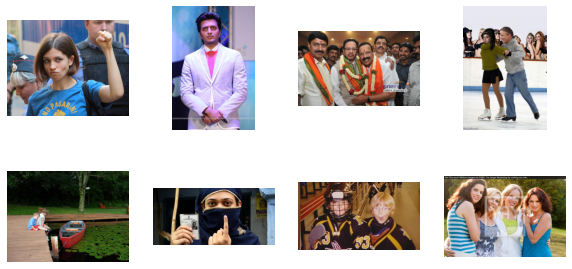

In [23]:
import matplotlib.pyplot as plt
from PIL import Image
img_folder = cfg['img_folder']
draw_save_folder = cfg['draw_save_folder']
conf_thre = 0.4
if not os.path.exists(img_folder):
    raise ValueError('Input image folder not exists.')
if not os.path.exists(draw_save_folder):
    os.mkdir(draw_save_folder)
ms.set_context(mode=ms.GRAPH_MODE, device_target='CPU', save_graphs=False)
# 存储所有图片
test_dataset = []
test_dataset = read_input_images(cfg['img_folder'])
num_images = len(test_dataset)
timers = {'forward_time': Timer(), 'misc': Timer()}
if cfg['val_origin_size']:
    h_max, w_max = 0, 0
    for image_path in test_dataset:
        image_read = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image_read.shape[0] > h_max:
            h_max = image_read.shape[0]
        if image_read.shape[1] > w_max:
            w_max = image_read.shape[1]
    h_max = (int(h_max / 32) + 1) * 32
    w_max = (int(w_max / 32) + 1) * 32
    priors = prior_box(image_sizes=(h_max, w_max),
                       min_sizes=ast.literal_eval(cfg['min_sizes']),
                       steps=cfg['steps'],
                       clip=cfg['clip'])
else:
    target_size = cfg['target_size']
    max_size = cfg['max_size']
    priors = prior_box(image_sizes=(max_size, max_size),
                       min_sizes=ast.literal_eval(cfg['min_sizes']),
                       steps=cfg['steps'],
                       clip=cfg['clip'])
detection = DetectionEngine(cfg)
print('Predict box starting')
# 展示加载的图片
plt.figure(figsize=(10, 5))
for i in range(1, 9):
    plt.subplot(2, 4, i)
    plt.imshow(Image.open(test_dataset[i-1]))
    plt.axis(False)
plt.show()

进行关键点预测：

In [24]:
print('Predict box starting')
for i, image_path in enumerate(test_dataset):
    img_raw = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = np.float32(img_raw)
    if cfg['val_origin_size']:
        resize = 1
        assert img.shape[0] <= h_max and img.shape[1] <= w_max
        image_t = np.empty((h_max, w_max, 3), dtype=img.dtype)
        image_t[:, :] = (104.0, 117.0, 123.0)
        image_t[0:img.shape[0], 0:img.shape[1]] = img
        img = image_t
    else:
        im_size_min = np.min(img.shape[0:2])
        im_size_max = np.max(img.shape[0:2])
        resize = float(target_size) / float(im_size_min)
        if np.round(resize * im_size_max) > max_size:
            resize = float(max_size) / float(im_size_max)
        img = cv2.resize(img, None, None, fx=resize, fy=resize, interpolation=cv2.INTER_LINEAR)
        assert img.shape[0] <= max_size and img.shape[1] <= max_size
        image_t = np.empty((max_size, max_size, 3), dtype=img.dtype)
        image_t[:, :] = (104.0, 117.0, 123.0)
        image_t[0:img.shape[0], 0:img.shape[1]] = img
        img = image_t
    scale = np.array([img.shape[1], img.shape[0], img.shape[1], img.shape[0]], dtype=img.dtype)
    ldm_scale = np.array(
        [img.shape[1], img.shape[0], img.shape[1], img.shape[0], img.shape[1], img.shape[0], img.shape[1],
         img.shape[0], img.shape[1], img.shape[0]], dtype=img.dtype)
    img -= (104, 117, 123)
    img = img.transpose(2, 0, 1)
    img = np.expand_dims(img, 0)
    img = Tensor(img)
    timers['forward_time'].start()
    boxes, confs, ldm = network(img)
    timers['forward_time'].end()
    timers['misc'].start()
    img_name = 'infer/' + os.path.split(image_path)[-1]
    detection.detect(boxes, ldm, confs, resize, scale, ldm_scale, img_name, priors)
    timers['misc'].end()
    print('im_detect: {:d}/{:d} forward_pass_time: {:.4f}s misc: {:.4f}s'.format(i + 1, num_images, timers['forward_time'].diff, timers['misc'].diff))
print('Predict box done.')

Predict box starting
im_detect: 1/8 forward_pass_time: 0.3380s misc: 0.0221s
im_detect: 2/8 forward_pass_time: 0.3351s misc: 0.0200s
im_detect: 3/8 forward_pass_time: 0.3694s misc: 0.0338s
im_detect: 4/8 forward_pass_time: 0.3753s misc: 0.0235s
im_detect: 5/8 forward_pass_time: 0.2968s misc: 0.0294s
im_detect: 6/8 forward_pass_time: 0.3529s misc: 0.0170s
im_detect: 7/8 forward_pass_time: 0.3671s misc: 0.0335s
im_detect: 8/8 forward_pass_time: 0.3342s misc: 0.0424s
Predict box done.


### 6.3 在图片上进行对齐框以及关键点绘画，并将图片进行保存

In [25]:
# 保存图片
save_img_list = []
def draw_image(pred_json, input_folder, save_folder, conf_threshold):
    for img_name in pred_json:
        input_path = os.path.join(input_folder, img_name + '.jpg')
        save_path = os.path.join(save_folder, img_name + '.jpg')
        bbox_to_draw = []
        landmark_to_draw = []
        processed_landmark = cast_list_to_int(pred_json[img_name]['landmarks'])
        for i, j in enumerate(pred_json[img_name]['bboxes']):
            x, y, width, height, conf = j
            if conf > conf_threshold:
                bbox_to_draw.append([int(x), int(y), int(width), int(height), conf])
                landmark_to_draw.append(processed_landmark[i])
        if not bbox_to_draw:
            continue
        frame = cv2.imread(input_path)
        img_det = draw_preds(frame, bbox_to_draw, landmark_list=processed_landmark)
        save_img_list.append(save_path)
        print('save_path:{}'.format(save_path))
        cv2.imwrite(save_path, img_det)

Draw image starting
save_path:/root/rtf/new_code/application_example/retinaface/infer_image/3_Riot_Riot_3_405.jpg
save_path:/root/rtf/new_code/application_example/retinaface/infer_image/4_Dancing_Dancing_4_494.jpg
save_path:/root/rtf/new_code/application_example/retinaface/infer_image/8_Election_Campain_Election_Campaign_8_244.jpg
save_path:/root/rtf/new_code/application_example/retinaface/infer_image/39_Ice_Skating_Ice_Skating_39_388.jpg
save_path:/root/rtf/new_code/application_example/retinaface/infer_image/43_Row_Boat_Rowboat_43_717.jpg
save_path:/root/rtf/new_code/application_example/retinaface/infer_image/56_Voter_peoplevoting_56_644.jpg
save_path:/root/rtf/new_code/application_example/retinaface/infer_image/58_Hockey_icehockey_puck_58_715.jpg
save_path:/root/rtf/new_code/application_example/retinaface/infer_image/12_Group_Group_12_Group_Group_12_144.jpg
Draw image done.


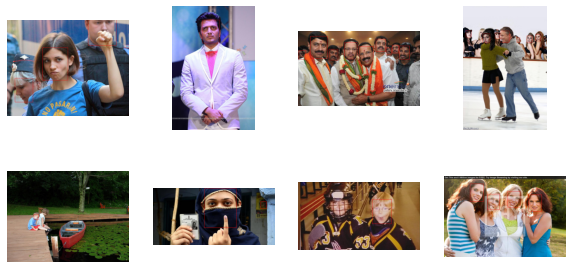

In [26]:
import matplotlib.pyplot as plt
image_average = cfg['image_average']
print('Draw image starting')
draw_image(detection.results['infer'], cfg['img_folder'], cfg['draw_save_folder'], cfg['conf_thre'])
print('Draw image done.')
# 展示绘画完毕的图片
plt.figure(figsize=(10, 5))
for i in range(1, 9):
    plt.subplot(2, 4, i)
    plt.imshow(Image.open(save_img_list[i-1]))
    plt.axis(False)
plt.show()

## 总结

本案例完整复现了RetinaFace网络的训练，验证和推理过程，也深入讲解了网络中的关键结构，如：FPN，anchor结构等。通过深入学习本案例，用户将深入了解RetinaFace网络的架构，理解网络的原理。通过自己调试代码中的关键参数，可以更好的帮助用户理解RetinaFace的核心要义。

## 引用

[1] Deng J ,  Guo J ,  Zhou Y , et al. RetinaFace: Single-stage Dense Face Localisation in the Wild[J].  2019.